# ML 3-class Classification  (DR4)

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7ff5de356e60>

MLfit applied to 4FGL-DR4 

Scikit-learn specifications: 
* features: log_var, log_fpeak, log_epeak, d
* classes: pulsar, bll, fsrq
* model: SVC(C=1, gamma=2)
        

## Feature distributions 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7ff5deba61a0>
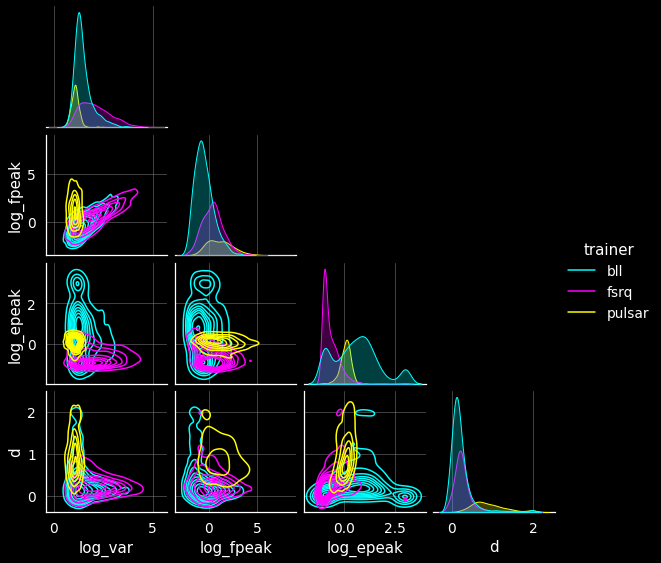

## Train then apply prediction 

### Precision-recall graph
These evaluations shows how well the pulsars are distinguished from blazars.
Comparison of our SVC model with the neural network alternative.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7ff5ddcb2110>
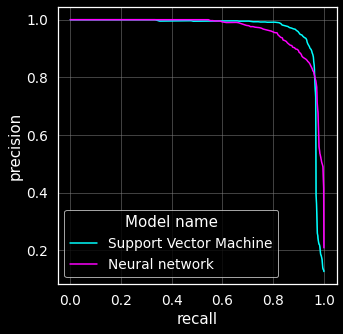

### All predictions

prediction,bll,fsrq,pulsar
association,,,
bll,1364,106,5
fsrq,152,651,5
psr,3,2,135
msp,5,5,166
glc,7,4,23
bcu,1030,424,100
spp,23,13,69
snr,16,1,24
other,64,42,25


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7ff5d9fe8b20>
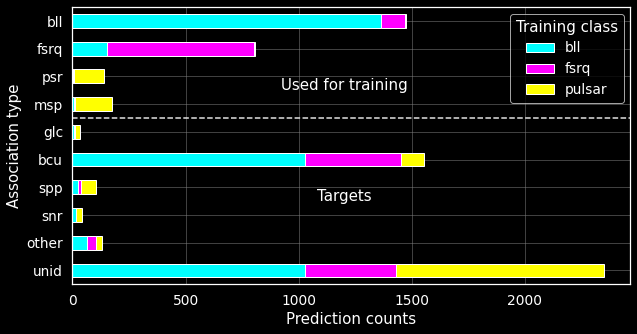

#### Write summary file, adding diffuse correlation

File `files/dr4_3_class_classification.csv` exists--not overwriting.


In [2]:
%run pylib/ml_fit show dark
self=doc(3,2)

In [4]:
show("""---
# Extra items""") 

---
# Extra items

In [3]:
df3 = pd.read_csv(f'files/dr4_3_class_classification.csv', index_col=0)
self.df['diffuse'] = df3.diffuse

---
## Compare $E_p$ vs $d$ for training and unid prediction

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7ff5d9e56aa0>
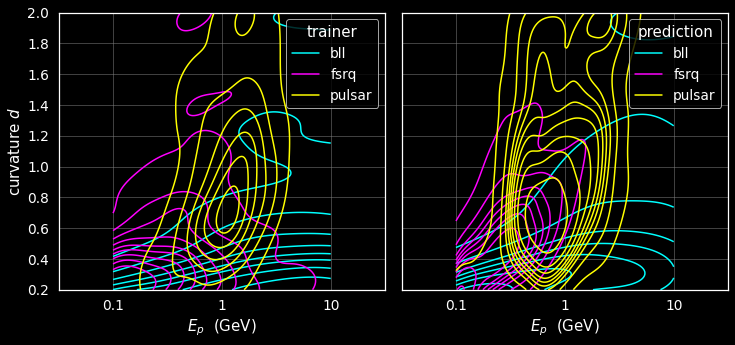

In [4]:
def ep_vs_d(self, df=None):
    # from pylib.tools import epeak_kw
    if df is None: df=self.df
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5),sharex=True,sharey=True,
                                gridspec_kw=dict(wspace=0.05))
    kw = dict( x='log_epeak', y='d',  palette=self.palette[:len(self.trainers)],
              clip=((-1,1),(0.2,2)),
              hue_order=self.trainer_names)
    
    sns.kdeplot(df,ax=ax1, hue=self.trainer_field, **kw)
    sns.kdeplot(df.query('association=="unid"'),ax=ax2, hue='prediction',**kw)

    ax1.set(**epeak_kw(),ylabel='curvature $d$', xlim=(-1.5,1.5)); ax2.set(**epeak_kw())
    return fig
show(f"""---
## Compare $E_p$ vs $d$ for training and unid prediction""")
show_fig(ep_vs_d, self)

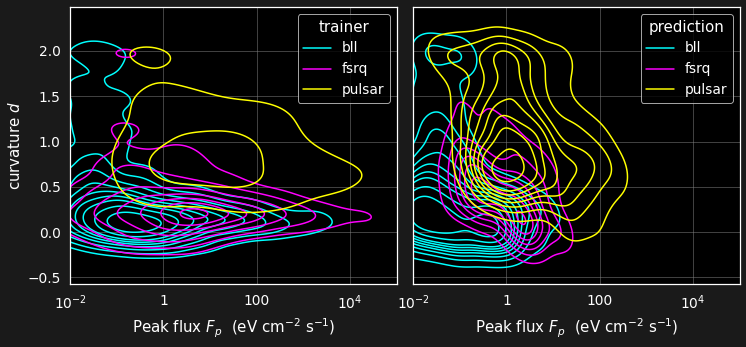

In [5]:
    def fp_vs_d(self, df=None):
        from pylib.tools import fpeak_kw
        if df is None: df=self.df
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5),sharex=True,sharey=True,
                                    gridspec_kw=dict(wspace=0.05))
        kw = dict( x='log_fpeak', y='d',  palette=self.palette[:len(self.trainers)],
                  hue_order=self.trainer_names)
        
        sns.kdeplot(df,ax=ax1, hue=self.trainer_field, **kw)
        sns.kdeplot(df.query('association=="unid"'),ax=ax2, hue='prediction',**kw)

        ax1.set(**fpeak_kw(),ylabel='curvature $d$'); ax2.set(**fpeak_kw())
        return fig
    fp_vs_d(self);

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbf0dbe8700>
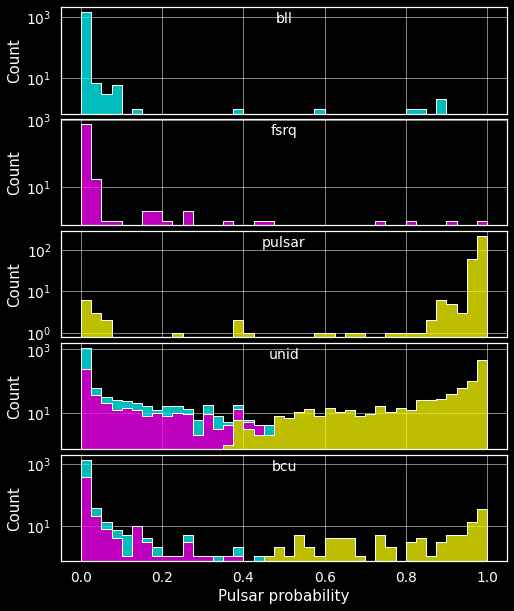

In [20]:
show_fig(self.pulsar_prob_hists, )

In [21]:
probs= self.predict_prob(query=None)
df = pd.concat([self.df, probs], axis=1)
d = {}
for non_target in ['unid','bcu', 'bll', 'fsrq', 'msp', 'psr']:
    unid = df.query(f'association=="{non_target}"').copy()
    d[non_target] = {'Total'     : len(unid),
         'predicted pulsar' : len(unid.query('prediction=="pulsar"')),
         'Likely blazar'    : len(unid.query('p_pulsar<0.15')),
         'Mystery'          : len(unid.query('0.95>p_pulsar>0.15')),
         'Mostly pulsars'   : len(unid.query('p_pulsar>0.95')),
        }
show(pd.DataFrame(d))

,unid,bcu,bll,fsrq,msp,psr
Total,2349,1554,1475,808,176,140
predicted pulsar,917,100,5,5,166,135
Likely blazar,1304,1434,1469,794,8,3
Mystery,474,73,6,13,22,6
Mostly pulsars,571,47,0,1,146,131


<Axes: xlabel='log_epeak', ylabel='d'>

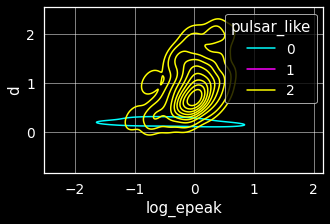

In [22]:
def pulsar_like(p):
    if p < 0.1: return 0
    if p < 0.95: return 1
    return 2
unid['pulsar_like'] = unid.p_pulsar.apply(pulsar_like)
sns.kdeplot(unid, x='log_epeak', y='d', hue='pulsar_like', palette=self.palette)


### Mystery

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbf0d7bb1c0>
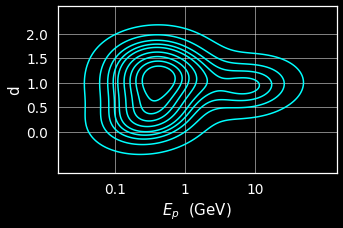

In [23]:
ax=sns.kdeplot(unid.query('0.95>p_pulsar>0.1'), color='cyan', x='log_epeak', y='d');
ax.set(**epeak_kw(), yticks=np.arange(0,2.1,0.5));
show(f"""### Mystery""")
show(ax.figure)

### Featues for unid's

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbf0ddb4040>
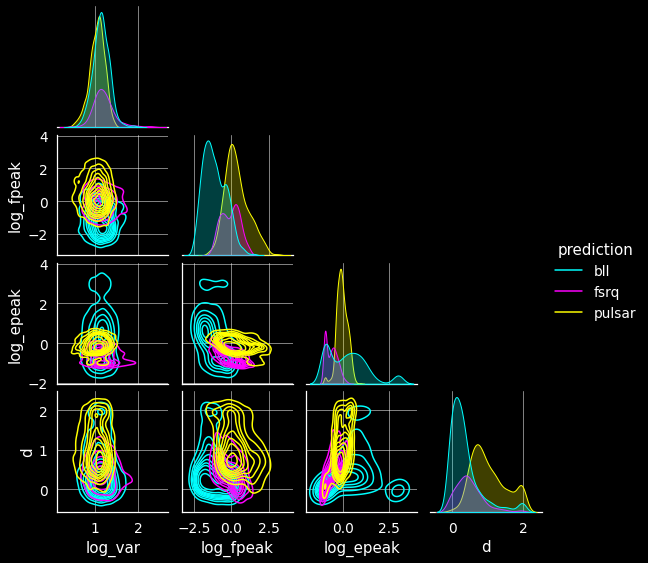

In [24]:
show("""### Featues for unid's""")
show_fig(self.pairplot, query='association=="unid"', hue='prediction');

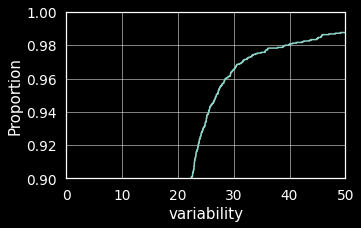

In [25]:
sns.ecdfplot(self.df.query('association=="unid"'), x='variability').set(xlim=(0,50), ylim=(0.9,1));#, element='step', bins=np.arange(0,40,1));

prediction,bll,fsrq,pulsar
0,1030,424,100


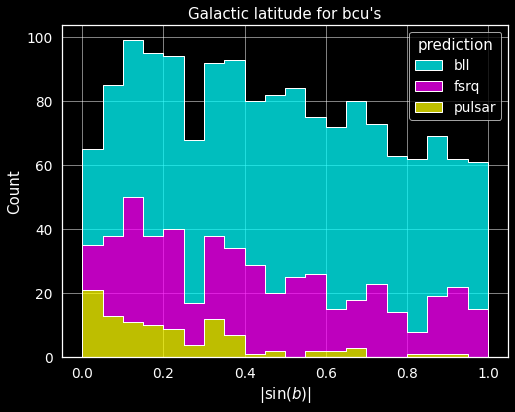

In [26]:
bcu = df.query('association=="bcu"')
show(bcu.groupby('prediction').size())
z = np.abs( np.abs(np.sin(np.radians(bcu.glat) )))
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(bcu, ax=ax, x=z, hue='prediction', palette=self.palette, 
             bins=np.arange(0,1.01,0.05), element='step', multiple='stack');
ax.set(xlabel=r'$|\sin(b)|$', title="Galactic latitude for bcu's") ;          

In [27]:
show("""---
## Confusion""")

---
## Confusion

In [28]:
cmdf = self.confusion_matrix()
show(cmdf)

prediction,bll,fsrq,pulsar
associations,,,
bll,1364,106,5
fsrq,152,651,5
pulsar,8,7,301


---
## Effect of the selection: "0.15<Ep<4  & variability<25"

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbf0db2a0e0>
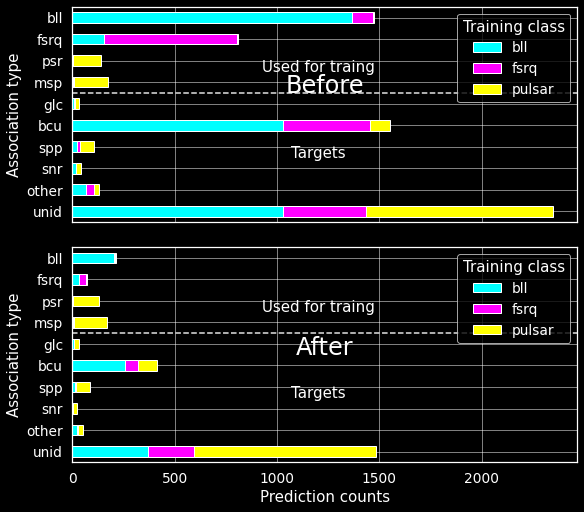

In [34]:
show(f"""---
## Effect of the selection: "{(cut:='0.15<Ep<4  & variability<25')}"
""")
tall = self.prediction_association_table()
df = self.df.copy().query(cut)
tsub=self.prediction_association_table(df);
fig, (ax1,ax2) = plt.subplots(layout='constrained', gridspec_kw=dict(hspace=0.1),
                              nrows=2, figsize=(8,7), sharex=True)
self.plot_prediction_association(table = tall, ax=ax1);
ax1.text(0.5,0.6, 'Before',  ha='center', fontsize=24, transform=ax1.transAxes)
self.plot_prediction_association(table = tsub, ax=ax2);
ax2.text(0.5,0.5, 'After', ha='center', fontsize=24, transform=ax2.transAxes)
show(fig)

---
## Effect of the selection
  "0.15<Ep<4 & d>0.2 & variability<25 & 0.2<diffuse<1.2"

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbf0db4ed40>
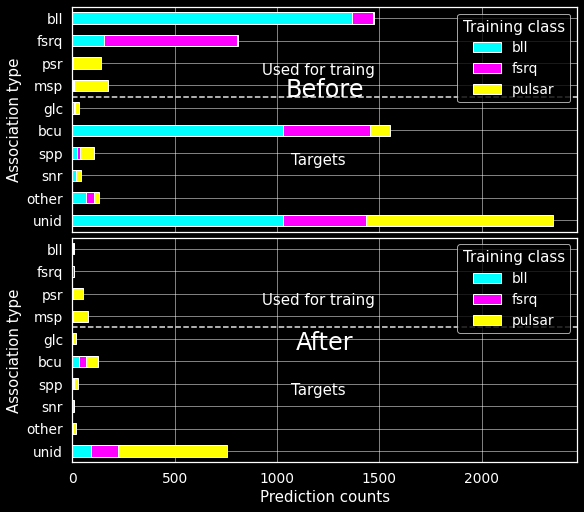

In [30]:
show(f"""---
## Effect of the selection
  "{(cut:='0.15<Ep<4 & d>0.2 & variability<25 & 0.2<diffuse<1.2')}"
""")
tall = self.prediction_association_table()
df = self.df.copy().query(cut)
tsub=self.prediction_association_table(df);
fig, (ax1,ax2) = plt.subplots(layout='constrained', nrows=2, figsize=(8,7), sharex=True)
self.plot_prediction_association(table = tall, ax=ax1);
ax1.text(0.5,0.6, 'Before',  ha='center', fontsize=24, transform=ax1.transAxes)
self.plot_prediction_association(table = tsub, ax=ax2);
ax2.text(0.5,0.5, 'After', ha='center', fontsize=24, transform=ax2.transAxes)
show(fig)